# Prep Data

Create a data table showing voter turnout rate by county for the 2016 Presidential election

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)

## Total Votes by County

Data taken from MIT Election Lab: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

In [3]:
votes_df = pd.read_csv('data/raw/MIT_countypres_2000-2016.csv')
votes_df.shape

(50524, 11)

In [4]:
# get 2016 only
votes_df = votes_df.query('year == 2016')

# get the county totals
votes_df = votes_df.groupby('FIPS').first().reset_index()

# convert FIPS to string
votes_df['FIPS'] = votes_df['FIPS'].apply(lambda x: str(int(x)).zfill(5))
votes_df.rename(columns={'totalvotes': 'totalVotes'}, inplace=True)

# take only the cols we need
votes_df = votes_df[['FIPS', 'totalVotes', 'county', 'state']]

votes_df.head()

,FIPS,totalVotes,county,state
0,01001,24973,Autauga,Alabama
1,01003,95215,Baldwin,Alabama
2,01005,10469,Barbour,Alabama
3,01007,8819,Bibb,Alabama
4,01009,25588,Blount,Alabama


In [5]:
votes_df.shape

(3155, 4)

# Voting Age Population by county

County level data from US Census, 2012-2016 American Community Survey 5 year estimates https://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.2016.html

**Note:** had to download, and resave the County.csv file with encoding as utf-8 

In [12]:
ls data/raw

ACS_CVAP_County.csv           usCounties.csv
MIT_countypres_2000-2016.csv


In [13]:
vap_df = pd.read_csv('data/raw/ACS_CVAP_County.csv')

In [14]:
vap_df.head()

,GEONAME,LNTITLE,GEOID,LNNUMBER,TOT_EST,TOT_MOE,ADU_EST,ADU_MOE,CIT_EST,CIT_MOE,CVAP_EST,CVAP_MOE
0,"Autauga County, Alabama",Total,05000US01001,1,55050,NaN,41195,34.0,54510,263,40690,236
1,"Autauga County, Alabama",Not Hispanic or Latino,05000US01001,2,53635,NaN,40290,35.0,53325,220,40015,184
2,"Autauga County, Alabama",American Indian or Alaska Native Alone,05000US01001,3,225,74.0,125,55.0,225,74,125,55
3,"Autauga County, Alabama",Asian Alone,05000US01001,4,485,165.0,390,106.0,340,200,245,161
4,"Autauga County, Alabama",Black or African American Alone,05000US01001,5,10115,242.0,7470,75.0,10115,242,7470,75


We want only the **TOTAL** rows

In [15]:
vap_df = vap_df[vap_df['LNNUMBER'] == 1]  # LNNUMBER = 1 is code for LNTITLE = Total

In [16]:
vap_df.shape

(3220, 12)

In [17]:
vap_df = vap_df[['GEONAME', 'GEOID', 'CVAP_EST', 'CVAP_MOE']]

In [18]:
vap_df.rename(
    columns = {
        'GEOID': 'FIPS',
        'CVAP_EST': 'VAP', 
        'CVAP_MOE':'VAP_MOE'}, 
    inplace=True)


In [19]:
vap_df['FIPS'] = vap_df['FIPS'].apply(lambda x: x[-5:])

In [20]:
vap_df['STATE'] = vap_df['GEONAME'].apply(lambda x: x.split(',')[1])

In [21]:
vap_df

,GEONAME,FIPS,VAP,VAP_MOE,STATE
0,"Autauga County, Alabama",01001,40690,236,Alabama
13,"Baldwin County, Alabama",01003,151770,680,Alabama
26,"Barbour County, Alabama",01005,20375,113,Alabama
39,"Bibb County, Alabama",01007,17590,81,Alabama
52,"Blount County, Alabama",01009,42430,314,Alabama
...,...,...,...,...,...
41795,"Vega Baja Municipio, Puerto Rico",72145,43335,90,Puerto Rico
41808,"Vieques Municipio, Puerto Rico",72147,7075,16,Puerto Rico
41821,"Villalba Municipio, Puerto Rico",72149,18270,52,Puerto Rico
41834,"Yabucoa Municipio, Puerto Rico",72151,27785,44,Puerto Rico


# Master list of all Counties

In [26]:
counties_df = pd.read_csv('data/raw/usCounties.csv')

In [27]:
counties_df.head()

,stateAbbrev,stateFIPS,countyFIPS,countyName,huh
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [28]:
def combineFIPS(row):
    state = str(row['stateFIPS']).zfill(2)
    county = str(row['countyFIPS']).zfill(3)
    
    return '{}{}'.format(state,county)

In [29]:
counties_df['FIPS'] = counties_df.apply(combineFIPS, axis=1)

In [30]:
counties_df = counties_df[['stateAbbrev', 'countyName', 'FIPS']]

In [31]:
counties_df.head()

,stateAbbrev,countyName,FIPS
0,AL,Autauga County,01001
1,AL,Baldwin County,01003
2,AL,Barbour County,01005
3,AL,Bibb County,01007
4,AL,Blount County,01009


In [32]:
counties_df.shape

(3235, 3)

# Combine

combined the vote tallies and vap for each county in the master county list

### total votes

In [34]:
df = counties_df.merge(votes_df[['totalVotes', 'FIPS']], how='left', on='FIPS')

In [35]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes
0,AL,Autauga County,01001,24973.0
1,AL,Baldwin County,01003,95215.0
2,AL,Barbour County,01005,10469.0
3,AL,Bibb County,01007,8819.0
4,AL,Blount County,01009,25588.0


In [36]:
df['totalVotes'].isnull().sum()

119

In [37]:
df.dropna(inplace=True)

## VAP

In [38]:
df = df.merge(vap_df[['VAP', 'STATE', 'FIPS']], how='left', on='FIPS')

In [39]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE
0,AL,Autauga County,01001,24973.0,40690.0,Alabama
1,AL,Baldwin County,01003,95215.0,151770.0,Alabama
2,AL,Barbour County,01005,10469.0,20375.0,Alabama
3,AL,Bibb County,01007,8819.0,17590.0,Alabama
4,AL,Blount County,01009,25588.0,42430.0,Alabama


In [40]:
df['VAP'].isnull().sum()

2

## Fix Alaska

Use the same VAP and totalVotes for each county in Alaska (which only reports at the state and precint level, not county). The total state values for Alaska come from MIT Elections Lab, returns by state: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/42MVDX/MFU99O&version=5.0

In [48]:
# Create a new set of counties for Alaska
AK_counties = counties_df[counties_df['stateAbbrev'] == 'AK']
AK_counties['STATE'] = 'Alaska'
AK_counties['totalVotes'] = 318608
AK_counties['VAP'] =  vap_df[vap_df['STATE'] == ' Alaska']['VAP'].sum()

# drop any existing AK rows
df = df[df['stateAbbrev'] != 'AK']

df = pd.concat([df, AK_counties])



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

# Calculate Voter Turnout Rates

In [50]:
def turnout(row):
    votes = row['totalVotes']
    vap = row['VAP']
    
    return votes/vap * 100

In [51]:
df['turnoutPerc'] = df.apply(turnout, axis=1)

In [52]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE,turnoutPerc
0,AL,Autauga County,01001,24973.0,40690.0,Alabama,61.373802
1,AL,Baldwin County,01003,95215.0,151770.0,Alabama,62.736377
2,AL,Barbour County,01005,10469.0,20375.0,Alabama,51.381595
3,AL,Bibb County,01007,8819.0,17590.0,Alabama,50.136441
4,AL,Blount County,01009,25588.0,42430.0,Alabama,60.306387


### Calculate Non voters and cleanup

In [53]:
# calculate non voters
df['nNonVote'] = df['VAP'] - df['totalVotes']

In [54]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,STATE,turnoutPerc,nNonVote
0,AL,Autauga County,01001,24973.0,40690.0,Alabama,61.373802,15717.0
1,AL,Baldwin County,01003,95215.0,151770.0,Alabama,62.736377,56555.0
2,AL,Barbour County,01005,10469.0,20375.0,Alabama,51.381595,9906.0
3,AL,Bibb County,01007,8819.0,17590.0,Alabama,50.136441,8771.0
4,AL,Blount County,01009,25588.0,42430.0,Alabama,60.306387,16842.0


In [55]:
# clear out the anomalous numbers
df['turnoutPerc'] = df['turnoutPerc'].apply(lambda x: x if x < 100 else 100)
df['nNonVote'] = df['nNonVote'].apply(lambda x: x if x >= 0 else 0)

In [56]:
# calculate the percent different from the overall US mean (55.5% of VAP in 2016 (wikipedia))
df['percFromMean'] = df['turnoutPerc'] - 55.5

In [57]:
df['STATE'] = df['STATE'].apply(lambda x: str(x).strip())
df.rename(columns={'STATE': 'state'}, inplace=True)

# summary of data

<AxesSubplot:>

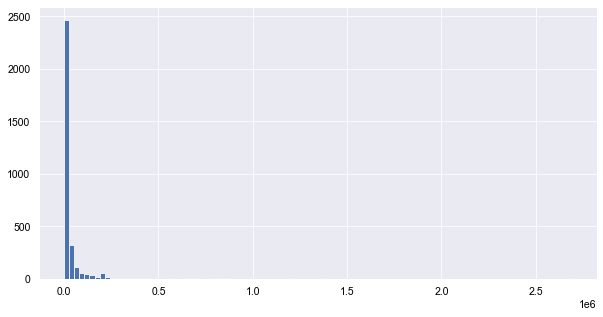

In [58]:
plt.figure(figsize=(10,5))
df['nNonVote'].hist(bins=100)

In [59]:
df['nNonVote'].max()

2689182.0

In [60]:
df.loc[df['nNonVote'].argmax()]

stateAbbrev               CA
countyName      Kings County
FIPS                   06031
totalVotes             33915
VAP                    91830
state             California
turnoutPerc          36.9324
nNonVote               57915
percFromMean        -18.5676
Name: 175, dtype: object

In [61]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
0,AL,Autauga County,01001,24973.0,40690.0,Alabama,61.373802,15717.0,5.873802
1,AL,Baldwin County,01003,95215.0,151770.0,Alabama,62.736377,56555.0,7.236377
2,AL,Barbour County,01005,10469.0,20375.0,Alabama,51.381595,9906.0,-4.118405
3,AL,Bibb County,01007,8819.0,17590.0,Alabama,50.136441,8771.0,-5.363559
4,AL,Blount County,01009,25588.0,42430.0,Alabama,60.306387,16842.0,4.806387


In [62]:
df[df['stateAbbrev'] == 'AK']

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
67,AK,Aleutians East Borough,02013,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
68,AK,Aleutians West Census Area,02016,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
69,AK,Anchorage Municipality,02020,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
70,AK,Bethel Census Area,02050,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
71,AK,Bristol Bay Borough,02060,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
72,AK,Denali Borough,02068,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
73,AK,Dillingham Census Area,02070,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
74,AK,Fairbanks North Star Borough,02090,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
75,AK,Haines Borough,02100,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574
76,AK,Hoonah-Angoon Census Area,02105,318608.0,527815.0,Alaska,60.363574,209207.0,4.863574


# Write out data

In [63]:
df.shape

(3142, 9)

In [64]:
df.dropna(inplace=True)

In [65]:
df.shape

(3140, 9)

In [66]:
df.to_csv('data/voterTurnout.csv', index=False)

## misc

In [48]:
strLen = df['countyName'].apply(lambda x: len(x))

<AxesSubplot:>

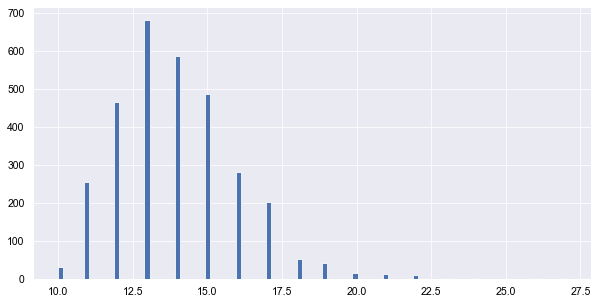

In [49]:
plt.figure(figsize=(10,5))
strLen.hist(bins=100)

In [50]:
strLen.max()

27

In [51]:
# county with the longest name
df.loc[strLen.argmax()]

stateAbbrev                              LA
countyName      St. John the Baptist Parish
FIPS                                  22095
totalVotes                            20743
VAP                                   31995
state                             Louisiana
turnoutPerc                          64.832
nNonVote                              11252
percFromMean                        9.33201
Name: 1133, dtype: object

<AxesSubplot:>

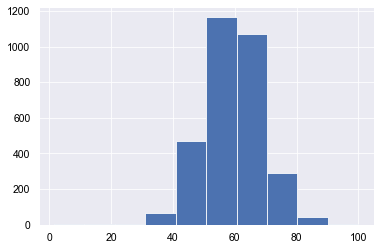

In [52]:
df['turnoutPerc'].hist()

In [53]:
df.query('turnoutPerc >= 99')

,stateAbbrev,countyName,FIPS,totalVotes,VAP,state,turnoutPerc,nNonVote,percFromMean
274,CO,San Juan County,08111,506.0,495.0,Colorado,100.0,0.0,44.5
1779,NM,Harding County,35021,527.0,470.0,New Mexico,100.0,0.0,44.5
2646,TX,Loving County,48301,65.0,60.0,Texas,100.0,0.0,44.5
2651,TX,McMullen County,48311,499.0,460.0,Texas,100.0,0.0,44.5


<AxesSubplot:>

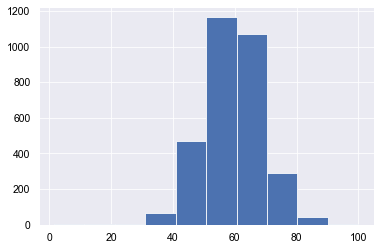

In [54]:
df['turnoutPerc'].hist()

In [55]:
df['turnoutPerc'].min()

1.4512856719885212